In [1]:
import pandas as pd
import numpy as np
import math
from numpy import array
########################################以下完成数据清洗##############################################
#数据清洗 按照file4，file5 清洗file1
df_1 = pd.read_csv('1. Transaction order_container.csv')
df_1 = df_1.dropna()
df_4 = pd.read_excel('4. Labels of C-S.xlsx').drop(columns=['.'])

# merge df_1 and df_4 to delete contract order.
df_1_file4 = pd.merge(df_1,df_4,on = 'WBL_NUM').replace(['EDI','CSO','CM'],np.nan).dropna()

# merge df_1_file4 and df_5 to delete SOC = 1 and Empty = 1
df_5 = pd.read_csv('5. Container information.csv').drop(columns = ['h','CNTR_TYPE'])
df_1_file4_file5 = pd.merge(df_1_file4,df_5,on = 'WBL_CNTR_UUID').replace(['1'],np.nan).dropna()

#去掉残留的列
df_1_file4_file5 = df_1_file4_file5.drop(columns = ['BKG_MTHD','IS_EMPTY','SOC'])

# 与 df_2 中的集装箱取交集，去掉特殊商品
df_2 = pd.read_csv('2. Transaction order_ordinary goods .csv').drop(columns = ['CNTR_TYPE','WBL_NUM','WBL_AUD_DT','CGO_BRIEF_DESC_NME','SVVD','AMT','PORT_BEGIN','PORT_END','SOC'])
df_1_file4_file5_file2 = pd.merge(df_1_file4_file5,df_2,on = 'WBL_CNTR_UUID').dropna()
df_1_file4_file5_file2.head()

#数据清洗完成，得到我们要处理的数据集:非合约普通商品，箱子不空，箱子不属于客户
df1 = df_1_file4_file5_file2
########################################

In [3]:
################################################以下给出第一问的10个流向，利用熵权法##################################################
#利用熵权法给出比重，取前十名

#整理数据形式，将箱子容量标准化为数字
df1 = df1.drop(columns = ['WBL_NUM','WBL_AUD_DT','CGO_BRIEF_DESC_NME','SVVD','IS_EMPTY'])
df1 = df1.replace(['20GP','20FL','20FS','20HQ','20OC','20OT','20RF','20TK'],20)
df1 = df1.replace(['40FL','40GP','40HQ','40OT','40RQ','40HQ','45HQ'],40)
df_1_vol_revenue = df1.groupby(by = ['PORT_BEGIN', 'PORT_END']).sum()
df_1_vol_revenue = df_1_vol_revenue.rename(columns={'CNTR_TYPE':  'sales_volume', 'AMT':'historical_revenue'})

In [6]:
##########熵权法##############
#定义熵值法函数
def cal_weight(x):
    '''熵值法计算变量的权重'''
    # 标准化
    x = x.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
 
    # 求k
    rows = x.index.size  # 行
    cols = x.columns.size  # 列
    k = 1.0 / math.log(rows)
 
    lnf = [[None] * cols for i in range(rows)]
 
    # 矩阵计算--
    # 信息熵
    # p=array(p)
    x = array(x)
    lnf = [[None] * cols for i in range(rows)]
    lnf = array(lnf)
    for i in range(0, rows):
        for j in range(0, cols):
            if x[i][j] == 0:
                lnfij = 0.0
            else:
                p = x[i][j] / x.sum(axis=0)[j]
                lnfij = math.log(p) * p * (-k)
            lnf[i][j] = lnfij
    lnf = pd.DataFrame(lnf)
    E = lnf
 
    # 计算冗余度
    d = 1 - E.sum(axis=0)
    # 计算各指标的权重
    w = [[None] * 1 for i in range(cols)]
    for j in range(0, cols):
        wj = d[j] / sum(d)
        w[j] = wj
        # 计算各样本的综合得分,用最原始的数据
    
    w = pd.DataFrame(w)
    return w

In [9]:
#利用该函数计算权重w
w = cal_weight(df_1_vol_revenue)  
w.index = df_1_vol_revenue.columns
w.columns = ['weight']

In [11]:
#利用权算分,结果里对应的weight列即为熵权法得分，这里仅展示前十名
df_1_vol_revenue_1 = df_1_vol_revenue.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
df_1_vol_revenue_1_weighted = df_1_vol_revenue_1.dot(w)
df_1_vol_revenue_1_weighted.sort_values(by=['weight'],ascending = False).head(10)

weight
PORT_BEGIN PORT_END          
营口         宁波        1.000000
新港         南沙        0.633092
营口         钦州        0.591325
乐从         营口        0.429523
钦州         日照        0.380658
营口         海口        0.365518
           南沙        0.321400
           福清        0.317655
钦州         宁波        0.303044
扬州         营口        0.274495

In [2]:
######################################以下完成第二问第一小题，给出偏好值#############################################
#求和算出销量和收入
df1 = df_1_file4_file5_file2
df1 = df1.replace(['20GP','20FL','20FS','20HQ','20OC','20OT','20RF','20TK'],20)
df1 = df1.replace(['40FL','40GP','40HQ','40OT','40RQ','40HQ','45HQ'],40)
df1 = df1.rename(columns={'CNTR_TYPE':  'sales_volume'})
df1 = df1.drop(columns = ['IS_EMPTY'])

#更改成时间序列类型
df1['WBL_AUD_DT'] = pd.to_datetime(df1['WBL_AUD_DT'])

In [3]:
#按照流向作分类，提取前十名的流向作为DataFrame
df1_grouped = df1.groupby(by = ['PORT_BEGIN', 'PORT_END'])
data1 = df1_grouped.get_group(('营口','宁波'))
data2 = df1_grouped.get_group(('新港','南沙'))
data3 = df1_grouped.get_group(('营口','钦州'))
data4 = df1_grouped.get_group(('乐从','营口'))
data5 = df1_grouped.get_group(('钦州','日照'))
data6 = df1_grouped.get_group(('营口','海口'))
data7 = df1_grouped.get_group(('营口','南沙'))
data8 = df1_grouped.get_group(('营口','福清'))
data9 = df1_grouped.get_group(('钦州','宁波'))
data10 = df1_grouped.get_group(('扬州','营口'))

In [85]:
#定义一个计算偏好值的函数，Input为某流向的数据集（dataframe格式，即上文中的data1、data2、...data10）,定义早晚的天数界x
#Output为prefer_value
def prefer(data,x):
    
    #得到船名列表：
    boats = list(set(list(data['SVVD'])))
    
    #复制备份
    data_c = data
    
    #数据按船名分类
    data = data.groupby(by = ['SVVD'])
    
    #设计一个循环，计算该流向的偏好值：
    prefer_boat = {}
    for boat in boats:
        boat_info = data.get_group(boat).drop(columns = ['WBL_CNTR_UUID','PORT_BEGIN','PORT_END'])
        boat_info = boat_info.sort_values(by=['WBL_AUD_DT'],ascending=False)
    #提取发船前三天内的箱子
        boat_info_late = boat_info[ boat_info['WBL_AUD_DT'] > boat_info.iloc[0,2] - x * pd.Timedelta('1 day')]
    
        late = len(set(list(boat_info_late['WBL_NUM'])))

    #提取发船前三天外的箱子
        boat_info_early = boat_info[ boat_info['WBL_AUD_DT'] <= boat_info.iloc[0,2] - x * pd.Timedelta('1 day')]
        early = len(set(list(boat_info_early['WBL_NUM'])))

    #计算该船的偏好值（早的赋值-1，晚的赋值1）
    
    #prefer_boat = prefer_boat.append({ boat:(late - early)/(late + early)})
        prefer_boat[boat] = (late - early)/(late + early)
    
#得到该流向船的偏好值表
    prefer_boat_df = pd.DataFrame(pd.Series(prefer_boat),columns = ['prefer_value'])
    prefer_boat_df['SVVD'] = prefer_boat_df.index

#计算加权平均，即该流向的偏好值
    data_weight = data_c.groupby(by = ['SVVD']).sum().drop(columns = ['AMT'])
    data_sum = pd.merge(data_weight,prefer_boat_df,on = ['SVVD'])
    prefer_value = (data_sum['prefer_value']*data_sum['sales_volume']).sum()/data_sum['sales_volume'].sum()
    return prefer_value

In [86]:
#下面调整参数x，使得其为最优
#在此假设10个流向的客户整体上没有订货早晚的偏好，故取其10个偏好值的和为0的x作为最优界
#定义偏好值的和 函数tiao_can_shi
def tiao_can_shi(x):
    return sum([prefer(data1,x),prefer(data2,x),prefer(data3,x),prefer(data4,x),prefer(data5,x),prefer(data6,x), \
                prefer(data7,x),prefer(data8,x),prefer(data9,x),prefer(data10,x)])

In [87]:
#先画一个函数图像，观察零点在哪里
s = np.linspace(0,10,100)

In [88]:
#得到函数值列：（此步运行时间较长）
y = []
for i in range(100):
    y.append(tiao_can_shi(s[i]))
y = np.array(y)

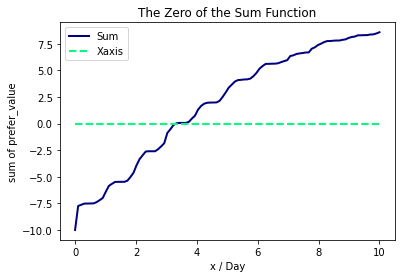

In [137]:
#画出图像，观察零点位置（过与简略，需要可视化处理）
l1 = plt.plot(s, y,linestyle = '-', # 折线类型
             linewidth = 2, # 折线宽度
             color = 'navy', # 折线颜色
             #marker = 'o', # 点的形状
             #markersize = 1, # 点的大小
             #markeredgecolor='black', # 点的边框色
             markerfacecolor='brown')
l2 = plt.plot(s,np.zeros(len(s)),linestyle = '--', # 折线类型
             linewidth = 2, # 折线宽度
             color = 'springgreen', # 折线颜色
             #marker = 'o', # 点的形状
             #markersize = 1, # 点的大小
             #markeredgecolor='black', # 点的边框色
             markerfacecolor='brown')

plt.title('The Zero of the Sum Function')
plt.xlabel('x / Day')
plt.ylabel('sum of prefer_value')

plt.legend(labels=['Sum','Xaxis'])

plt.savefig('the zero of the sum function.png')

plt.show()




In [90]:

#观察图像后觉得用二分法比较合理

# 限定求根范围的最大最小值
MIN = 0
MAX = 10

# 创建MID的函数值逼近0的永循环
while True:
    #i += 1
    MID = (MIN + MAX) / 2       # 计算中值
    fun_min = tiao_can_shi(MIN)
    fun_max = tiao_can_shi(MAX)
    fun_mid = tiao_can_shi(MID)
    #print(i, MID, fun_mid)
    if abs(fun_mid) < 0.01:   # 当误差小于设定范围时，输出值
        print('函数的在(0，10)上的根为:  ',end='')
        print(MID)
        break
    elif fun_min * fun_mid < 0:
        MAX = MID
    else:
        MIN = MID

函数的在(0，10)上的根为:  3.30078125


In [92]:
#此即最优参数，计算得此时偏好值信息：
x = 3.30078125
[prefer(data1,x),prefer(data2,x),prefer(data3,x),prefer(data4,x),prefer(data5,x),prefer(data6,x), \
 prefer(data7,x),prefer(data8,x),prefer(data9,x),prefer(data10,x)]

[-0.6720226497452317,
 0.10722618265099701,
 0.14009060207306587,
 0.02063049000151944,
 -0.41241616794826613,
 -0.047250358663873754,
 0.2126484875983,
 0.33483008454319096,
 0.20684462201528928,
 0.11443932888452055]

In [ ]:
######################################以下完成第二问第二小题，给出日销量与价格的关系########################################

In [ ]:
#############################################以下行可能运行很久，我运行了一分钟多##########################################################
#消除警告
import warnings
warnings.filterwarnings("ignore")

#导入数据3，将利用数据三检查集装箱是否有中转、empty等问题
xlsx = pd.ExcelFile("3. Contain route.xlsx")
d1 = pd.read_excel(xlsx, "2.xlsx")
d2 = pd.read_excel(xlsx, "Sheet1")
d2.columns = list(d1.columns)
df_3 = pd.concat([d1,d2],ignore_index=True)
del d1,d2

In [17]:
#下面以data1 营口到宁波为例，考察销量与价格的关系 
#按集装箱号取交集方便索引（与df_3“杂交”）
data1_contain_info = pd.merge(data1,df_3,how = 'inner',on = 'WBL_CNTR_UUID')

In [18]:
#test：
data1_contain_info['SEQ_NUM'].value_counts()
#（根据out，）所有集装箱均为第一次运输，即都是直达，可以不区分货物种类

1    4474
Name: SEQ_NUM, dtype: int64

In [19]:
#test：
data1_contain_info['IS_EMPTY'].value_counts()
#（根据out，）所有集装箱均非空，不需要丢掉某些

0    4474
Name: IS_EMPTY, dtype: int64

In [20]:
#只保留需要的列
data1_time_sale_price = data1_contain_info[['sales_volume','WBL_AUD_DT','AMT']]

#按时间排一个升序
data1_time_sale_price.sort_values(by = ['WBL_AUD_DT'])

#忽略时间小时、分钟，按天统计
data1_time_sale_price['WBL_AUD_DT'] = data1_time_sale_price['WBL_AUD_DT'].apply(lambda x : x.to_period('D'))

In [21]:
#test：
data1_contain_info['sales_volume'].value_counts()
#（根据out）40的占绝少部分，故筛去40的（为控制变量，仅考虑20的）

20    4453
40      21
Name: sales_volume, dtype: int64

In [22]:
#筛去40的箱子
data1_time_sale_price = data1_time_sale_price.replace([40],np.nan).dropna()

In [23]:
#求出日销量series
data1_time_sale_price_Vol = data1_time_sale_price.groupby(by = ['WBL_AUD_DT'])['sales_volume'].sum()

#根据条件，普通商品价格可视为相同，故可取 均值 得到日售价series
data1_time_sale_price_Pri = data1_time_sale_price.groupby(by = ['WBL_AUD_DT'])['AMT'].mean()

#合并两个series
data1_time_sale_price_m = pd.merge(data1_time_sale_price_Vol,data1_time_sale_price_Pri,on = 'WBL_AUD_DT')

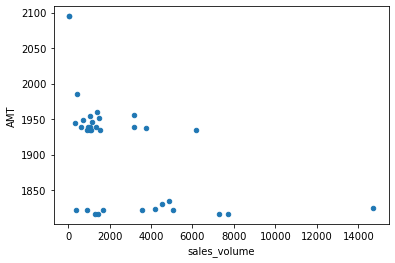

In [24]:
#画出散点图：

################并不美观，这里要在可视化上下点功夫，把图作的好看一些##############

data1_time_sale_price_m.plot.scatter(x='sales_volume', y='AMT')

In [ ]:
#可以用以下语句将以上散点图的数据导出，作拟合
#data1_time_sale_price_m.to_csv('data1_time_sale_price_m')

In [26]:
#为简便，将以上过程用函数表示：
#定义一个函数，输入流向数据集（dataframe格式，即上文中的data1、data2、...data10），输出散点图

#####在函数里筛去40的箱子那一步，可以将语句里的40改成20，就保存40的箱子，筛去20的箱子

def relation(data):
    data_contain_info = pd.merge(data,df_3,how = 'inner',on = 'WBL_CNTR_UUID')
    #只保留需要的列
    data_time_sale_price = data_contain_info[['sales_volume','WBL_AUD_DT','AMT']]
    #按时间排一个升序
    data_time_sale_price.sort_values(by = ['WBL_AUD_DT'])
    #忽略时间小时、分钟，按天统计
    data_time_sale_price['WBL_AUD_DT'] = data_time_sale_price['WBL_AUD_DT'].apply(lambda x : x.to_period('D'))
    #筛去40的箱子
    data_time_sale_price = data_time_sale_price.replace([40],np.nan).dropna()
    #求出日销量series
    data_time_sale_price_Vol = data_time_sale_price.groupby(by = ['WBL_AUD_DT'])['sales_volume'].sum()
    #根据条件，普通商品价格可视为相同，故可取 均值 得到日售价series
    data_time_sale_price_Pri = data_time_sale_price.groupby(by = ['WBL_AUD_DT'])['AMT'].mean()
    #合并两个series
    data_time_sale_price_m = pd.merge(data_time_sale_price_Vol,data_time_sale_price_Pri,on = 'WBL_AUD_DT')
    #画散点图
    data_time_sale_price_m.plot.scatter(x='sales_volume', y='AMT')
    
#关系由数据或散点图得出，此处从略。

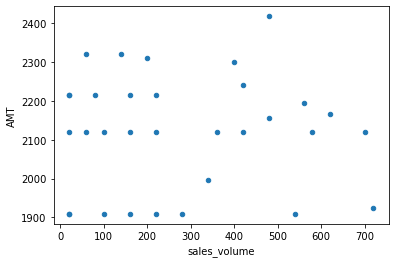

In [27]:
import warnings
warnings.filterwarnings("ignore")
relation(data2)
#此处可多次改变输入，如data3，data7，看看相应的散点图，发现还是选1最好

In [ ]:
#########################################以下完成第二大问第三小问，即给出短期预测（以下为data1的）###########################################

In [28]:
import matplotlib.pyplot as plt

In [29]:
#以下企图采用灰色预测法（失败尝试）
#补充缺失天数
data1_time_sale_price_m = data1_time_sale_price_m.resample("D").mean().fillna(0)
#data1_time_sale_price_m.info()

#补充新的一列作为日期index的copy，作为画图的横坐标
data1_time_sale_price_m['index'] = data1_time_sale_price_m.index
data1_time_sale_price_m['index'] = data1_time_sale_price_m['index'].astype(str)

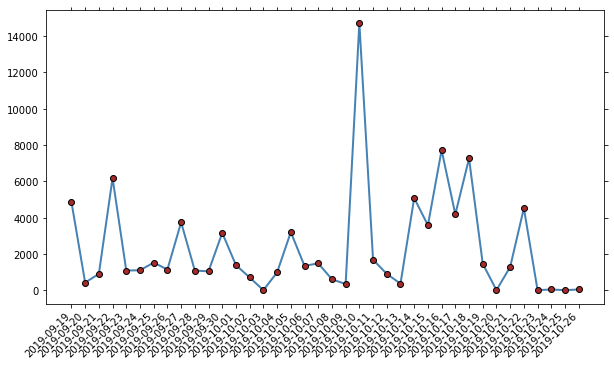

In [30]:
#试图画出来折线图：

# 设置图框的大小
fig = plt.figure(figsize = (10,6))

plt.plot(data1_time_sale_price_m['index'],data1_time_sale_price_m['sales_volume'],linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
         color = 'steelblue', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 6, # 点的大小
         markeredgecolor='black', # 点的边框色
         markerfacecolor='brown')
plt.title('')
plt.xlabel('')
plt.ylabel('')
# 剔除图框上边界和右边界的刻度
plt.tick_params(top = 'off', right = 'off')

# 为了避免x轴日期刻度标签的重叠，设置x轴刻度自动展现，并且45度倾斜
fig.autofmt_xdate(rotation = 45)

# 显示图形
plt.show()

#############同样，图形并不美观，需要在可视化上下点功夫##########


In [31]:
x = np.array(data1_time_sale_price_m['sales_volume'])
#为满足级比要求，先对数据进行适当平移（灰色预测模型专业术语）
x = x+100000

In [32]:
#利用他人函数
def GM11(x,n):
    '''
    灰色预测
    x：序列，numpy对象
    n:需要往后预测的个数
    '''
    x1 = x.cumsum()#一次累加  
    z1 = (x1[:len(x1) - 1] + x1[1:])/2.0#紧邻均值  
    z1 = z1.reshape((len(z1),1))  
    B = np.append(-z1,np.ones_like(z1),axis=1)  
    Y = x[1:].reshape((len(x) - 1,1))
    #a为发展系数 b为灰色作用量
    [[a],[b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Y)#计算参数  
    result = (x[0]-b/a)*np.exp(-a*(n-1))-(x[0]-b/a)*np.exp(-a*(n-2))  
    S1_2 = x.var()#原序列方差
    e = list()#残差序列
    for index in range(1,x.shape[0]+1):
        predict = (x[0]-b/a)*np.exp(-a*(index-1))-(x[0]-b/a)*np.exp(-a*(index-2))
        e.append(x[index-1]-predict)
    S2_2 = np.array(e).var()#残差方差
    C = S2_2/S1_2#后验差比
    if C<=0.35:
        assess = '后验差比<=0.35，模型精度等级为好'
    elif C<=0.5:
        assess = '后验差比<=0.5，模型精度等级为合格'
    elif C<=0.65:
        assess = '后验差比<=0.65，模型精度等级为勉强'
    else:
        assess = '后验差比>0.65，模型精度等级为不合格'
    #预测数据
    predict = list()
    for index in range(x.shape[0]+1,x.shape[0]+n+1):
        predict.append((x[0]-b/a)*np.exp(-a*(index-1))-(x[0]-b/a)*np.exp(-a*(index-2)))
    predict = np.array(predict)
    return {
            'a':{'value':a,'desc':'发展系数'},
            'b':{'value':b,'desc':'灰色作用量'},
            'predict':{'value':result,'desc':'第%d个预测值'%n},
            'C':{'value':C,'desc':assess},
            'predict':{'value':predict,'desc':'往后预测%d个的序列'%(n)},
            }

In [33]:
#预测，发现不合格
GM11(x,5)

{'a': {'value': -0.00013871313494495316, 'desc': '发展系数'},
 'b': {'value': 101998.89670875546, 'desc': '灰色作用量'},
 'predict': {'value': array([102545.47245657, 102559.69784725, 102573.92521107, 102588.15454876,
         102602.38586009]),
  'desc': '往后预测5个的序列'},
 'C': {'value': 1.0018027643359044, 'desc': '后验差比>0.65，模型精度等级为不合格'}}

In [34]:
#利用他人灰色预测函数检测是否有和要求的流向（发现没有）
#该函数输入为流向数据集，输出即为GM11的输出
def grey_pre(data):
    data_contain_info = pd.merge(data,df_3,how = 'inner',on = 'WBL_CNTR_UUID')
    #只保留需要的列
    data_time_sale_price = data_contain_info[['sales_volume','WBL_AUD_DT','AMT']]
    #按时间排一个升序
    data_time_sale_price.sort_values(by = ['WBL_AUD_DT'])
    #忽略时间小时、分钟，按天统计
    data_time_sale_price['WBL_AUD_DT'] = data_time_sale_price['WBL_AUD_DT'].apply(lambda x : x.to_period('D'))
    #筛去40的箱子
    data_time_sale_price = data_time_sale_price.replace([40],np.nan).dropna()
    #求出日销量series
    data_time_sale_price_Vol = data_time_sale_price.groupby(by = ['WBL_AUD_DT'])['sales_volume'].sum()
    #根据条件，普通商品价格可视为相同，故可取 均值 得到日售价series
    data_time_sale_price_Pri = data_time_sale_price.groupby(by = ['WBL_AUD_DT'])['AMT'].mean()
    #合并两个series
    data_time_sale_price_m = pd.merge(data_time_sale_price_Vol,data_time_sale_price_Pri,on = 'WBL_AUD_DT')
    
    #补充缺失天数
    data_time_sale_price_m = data_time_sale_price_m.resample("D").mean().fillna(0)
    #data1_time_sale_price_m.info()

    #补充新的一列作为日期index的copy，作为画图的横坐标
    data_time_sale_price_m['index'] = data_time_sale_price_m.index
    data_time_sale_price_m['index'] = data_time_sale_price_m['index'].astype(str)
    x = np.array(data_time_sale_price_m['sales_volume'])
    x = x/20+1000
    return GM11(x,5)

In [35]:
####################这里尝试多个流向####################
grey_pre(data3)

{'a': {'value': -0.0017669011661090683, 'desc': '发展系数'},
 'b': {'value': 988.6206544855108, 'desc': '灰色作用量'},
 'predict': {'value': array([1092.51145166, 1094.4435178 , 1096.37900073, 1098.31790648,
         1100.26024113]),
  'desc': '往后预测5个的序列'},
 'C': {'value': 0.9024804607103178, 'desc': '后验差比>0.65，模型精度等级为不合格'}}

In [ ]:
#灰色预测都不行，放弃

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


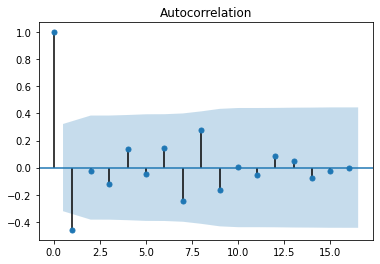

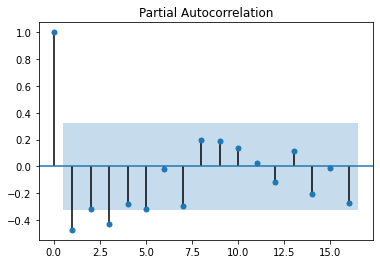

In [36]:
#企图使用ARIMA模型（最终使用的模型）
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

series = np.array(data1_time_sale_price_m['sales_volume'])
n = 1
series = np.array(series)
series = pd.Series(series.reshape(-1))
currentDir = os.getcwd()#当前工作路径
    #为得到平稳时间序列，我们先尝试进行一阶差分
    #一阶差分数据
fd = series.diff(1)[1:]
plot_acf(fd).savefig(currentDir+'/一阶差分自相关图.eps',dpi=600,format='eps')
plot_pacf(fd).savefig(currentDir+'/一阶差分偏自相关图.eps',dpi=600,format='eps')

In [37]:
#一阶差分单位根检验
unitP = adfuller(fd)[1]
if unitP>0.05:
    print('单位根检验中p值为%.8f，大于0.05，认为该一阶差分序列判断为非平稳序列'%(unitP))
else:
    print('单位根检验中p值为%.8f，小于0.05，认为该一阶差分序列判断为平稳序列'%(unitP))

#可见一阶差分已经是平稳序列

单位根检验中p值为0.00000004，小于0.05，认为该一阶差分序列判断为平稳序列


In [38]:
#白噪声检验
noiseP = acorr_ljungbox(fd, lags=1)[-1]
if noiseP<=0.05:
    print('白噪声检验中p值为%.8f，小于0.05，认为该一阶差分序列为非白噪声'%noiseP)
else:
    print('白噪声检验中%.8f，大于0.05，认为该一阶差分序列为白噪声'%noiseP)

白噪声检验中p值为0.00355393，小于0.05，认为该一阶差分序列为非白噪声


In [39]:
#BIC准则确定p、q值
pMax = int(series.shape[0]/10)# 一般阶数不超过length/10
qMax = pMax# 一般阶数不超过length/10
bics = list()
for p in range(pMax + 1):
    tmp = list()
    for q in range(qMax + 1):
        try:
            tmp.append(arima_model.ARIMA(series, (p, 1, q)).fit().bic)
        except Exception as e:
                #print(str(e))
            tmp.append(1e+10)#加入一个很大的数
    bics.append(tmp)
bics = pd.DataFrame(bics)
p, q = bics.stack().idxmin()
print('BIC准则下确定p,q为%s,%s'%(p,q))

BIC准则下确定p,q为0,1


In [40]:
    #建模预测得下一天的销量值
model = arima_model.ARIMA(series,order=(p, 1, q)).fit()
predict = model.forecast(n)[0]
print(predict)

[2458.90822925]


In [ ]:
#############再给出两个不同的预测（data2与data6）##################
######################以下两个可以不运行，结果我已经保存，直接放入文章即可####################

In [ ]:
##################################导入ARIMA函数############################
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")


def ARIMA(series,n):
    '''
    只讨论一阶差分的ARIMA模型，预测，数字索引从1开始
    series:时间序列
    n:需要往后预测的个数
    '''
    series = np.array(series)
    series = pd.Series(series.reshape(-1))
    currentDir = os.getcwd()#当前工作路径
    #一阶差分数据
    fd = series.diff(1)[1:]
    plot_acf(fd).savefig(currentDir+'/一阶差分自相关图.png')
    plot_pacf(fd).savefig(currentDir+'/一阶差分偏自相关图.png')
    #一阶差分单位根检验
    unitP = adfuller(fd)[1]
    if unitP>0.05:
        unitAssess = '单位根检验中p值为%.2f，大于0.05，认为该一阶差分序列判断为非平稳序列'%(unitP)
        #print('单位根检验中p值为%.2f，大于0.05，认为该一阶差分序列判断为非平稳序列'%(unitP))
    else:
        unitAssess = '单位根检验中p值为%.2f，小于0.05，认为该一阶差分序列判断为平稳序列'%(unitP)
        #print('单位根检验中p值为%.2f，小于0.05，认为该一阶差分序列判断为平稳序列'%(unitP))
    #白噪声检验
    noiseP = acorr_ljungbox(fd, lags=1)[-1]
    if noiseP<=0.05:
        noiseAssess = '白噪声检验中p值为%.2f，小于0.05，认为该一阶差分序列为非白噪声'%noiseP
        #print('白噪声检验中p值为%.2f，小于0.05，认为该一阶差分序列为非白噪声'%noiseP)
    else:
        noiseAssess = '白噪声检验中%.2f，大于0.05，认为该一阶差分序列为白噪声'%noiseP
        #print('白噪声检验中%.2f，大于0.05，认为该一阶差分序列为白噪声'%noiseP)
    #BIC准则确定p、q值
    pMax = int(series.shape[0]/10)# 一般阶数不超过length/10
    qMax = pMax# 一般阶数不超过length/10
    bics = list()
    for p in range(pMax + 1):
        tmp = list()
        for q in range(qMax + 1):
            try:
                tmp.append(arima_model.ARIMA(series, (p, 1, q)).fit().bic)
            except Exception as e:
                #print(str(e))
                tmp.append(1e+10)#加入一个很大的数
        bics.append(tmp)
    bics = pd.DataFrame(bics)
    p, q = bics.stack().idxmin()
    #print('BIC准则下确定p,q为%s,%s'%(p,q))
    #建模
    model = arima_model.ARIMA(series,order=(p, 1, q)).fit()
    predict = model.forecast(n)[0]
    return {
            'model':{'value':model,'desc':'模型'},
            'unitP':{'value':unitP,'desc':unitAssess},
            'noiseP':{'value':noiseP[0],'desc':noiseAssess},
            'p':{'value':p,'desc':'AR模型阶数'},
            'q':{'value':q,'desc':'MA模型阶数'},
            'params':{'value':model.params,'desc':'模型系数'},
            'predict':{'value':predict,'desc':'往后预测%d个的序列'%(n)}
            }

In [ ]:
#该函数输入为流向数据集,输出为相应的销量随时间的折线图，和ARIMA预测结果
def Plot_ARIMA(data):
    data_contain_info = pd.merge(data,df_3,how = 'inner',on = 'WBL_CNTR_UUID')
    #只保留需要的列
    data_time_sale_price = data_contain_info[['sales_volume','WBL_AUD_DT','AMT']]
    #按时间排一个升序
    data_time_sale_price.sort_values(by = ['WBL_AUD_DT'])
    #忽略时间小时、分钟，按天统计
    data_time_sale_price['WBL_AUD_DT'] = data_time_sale_price['WBL_AUD_DT'].apply(lambda x : x.to_period('D'))
    #筛去40的箱子
    data_time_sale_price = data_time_sale_price.replace([40],np.nan).dropna()
    #求出日销量series
    data_time_sale_price_Vol = data_time_sale_price.groupby(by = ['WBL_AUD_DT'])['sales_volume'].sum()
    #根据条件，普通商品价格可视为相同，故可取 均值 得到日售价series
    data_time_sale_price_Pri = data_time_sale_price.groupby(by = ['WBL_AUD_DT'])['AMT'].mean()
    #合并两个series
    data_time_sale_price_m = pd.merge(data_time_sale_price_Vol,data_time_sale_price_Pri,on = 'WBL_AUD_DT')
    
    #补充缺失天数
    data_time_sale_price_m = data_time_sale_price_m.resample("D").mean().fillna(0)
    #data1_time_sale_price_m.info()

    #补充新的一列作为日期index的copy，作为画图的横坐标
    data_time_sale_price_m['index'] = data_time_sale_price_m.index
    data_time_sale_price_m['index'] = data_time_sale_price_m['index'].astype(str)
    
    #保存数据文件
    data_time_sale_price_m.to_csv('data_time_sale_price_m.csv')
    
    #试图画出来折线图：

# 设置图框的大小
    fig = plt.figure(figsize = (10,6))

    plt.plot(data_time_sale_price_m['index'],data_time_sale_price_m['sales_volume'],linestyle = '-', # 折线类型
             linewidth = 2, # 折线宽度
             color = 'steelblue', # 折线颜色
             marker = 'o', # 点的形状
             markersize = 6, # 点的大小
             markeredgecolor='black', # 点的边框色
             markerfacecolor='brown')
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
# 剔除图框上边界和右边界的刻度
    plt.tick_params(top = 'off', right = 'off')

# 为了避免x轴日期刻度标签的重叠，设置x轴刻度自动展现，并且45度倾斜
    fig.autofmt_xdate(rotation = 45)

# 显示图形
    plt.show()
    
    #预测
    return ARIMA(data_time_sale_price_m['sales_volume'],1)
    

In [41]:
#分别用两次以上函数：
#Plot_ARIMA(data2)
#Plot_ARIMA(data6)
#运行结果我已经保存

In [96]:
###############################################以下完成第三题##################################################

######################以下结果不需要先前导入的任何数据集，但需要导入的package，如numpy等##########################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [97]:
#读入df_6
df_6 = pd.read_excel('6. Existing pricing strategy.xlsx')

In [98]:
#重命名columns（中文变英文）
columns_6 = ['route','direction','PORT_BEGIN','PORT_END','good_type','begin_day','end_day','season','strategy','Threshold','20GP','40GP','40HQ']
df_6.columns = columns_6

In [99]:
#对df_6中的数据按出发和终止分组：
df_6_grouped = df_6.groupby(by = ['PORT_BEGIN','PORT_END'])

In [100]:
#对我们之前研究的10个流向检验，结果发现只有第九个流向在df_6里有，所以以下讨论第九个流向
df_6_data9 = df_6_grouped.get_group(('钦州','宁波'))

In [ ]:
###############################计算该航向的舱位利用率###################################

In [101]:
#因为仓位不管是不是特殊商品，都要占据，所以回到清洗前的数据。
df_1_spu_rate = pd.read_csv('1. Transaction order_container.csv').dropna()

In [102]:
#在df_1中所有箱子里，提取该流向的箱子：
df_1_squ_rate_data9 = df_1_spu_rate.groupby(by = ['PORT_BEGIN','PORT_END']).get_group(('钦州','宁波'))

In [103]:
#因为空间占用率是针对某一航次的，所以以下提取航次：
#提取该流向的航次：
df_1_squ_rate_data9_SVVDgrouped = df_1_squ_rate_data9.groupby(by = ['SVVD'])

In [104]:
#展示该流向都有哪些航次
df_1_squ_rate_data9_SVVDgrouped['AMT'].sum()

SVVD
IC19-CAC-187 N    153293.70
IC19-CAE-199 N    151882.50
IC19-CAE-200 N    248770.20
IC19-CAJ-159 N    199492.65
IC19-CAJ-160 N     61012.35
IC19-CAL-191 N    200056.50
IC19-CAL-192 N    127060.50
IC39-TDB-042 N    105676.20
Name: AMT, dtype: float64

In [105]:
#对该流向，提取'IC19-CAC-187 N'航次，先作分析，命名为route1
df_1_squ_rate_data9_SVVDgrouped_route1 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAC-187 N'))

In [106]:
#与df_5对比，得到空箱子是谁
#导入df_5 只保留我们需要的列
df_5 = pd.read_csv('5. Container information.csv').drop(columns = ['h','CNTR_TYPE','SOC'])

In [13]:
#merge两个dataframe，进一步对比
df_1_squ_rate_data9_SVVDgrouped_route1_with5 = pd.merge(df_1_squ_rate_data9_SVVDgrouped_route1,df_5,on = ['WBL_CNTR_UUID'])

In [14]:
#检查有无空箱子
df_1_squ_rate_data9_SVVDgrouped_route1_with5['IS_EMPTY'].value_counts()
#好家伙，箱子全满，说明最后确实都塞满了

0    613
Name: IS_EMPTY, dtype: int64

In [15]:
#只保留我们需要的列
df_1_squ_rate_data9_SVVDgrouped_route1_with5 = df_1_squ_rate_data9_SVVDgrouped_route1_with5[['CNTR_TYPE','WBL_NUM','WBL_AUD_DT','IS_EMPTY']]

In [107]:
#汇总为一个函数，输入航次
#输出随时间变化的空间占用率，同时输出表格并画出折线图
def cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route1):
    #
    #这里已经导入df_5
    #导入df_5 只保留我们需要的列
    #df_5 = pd.read_csv('5. Container information.csv').drop(columns = ['h','CNTR_TYPE','SOC'])
    #
    df_1_squ_rate_data9_SVVDgrouped_route1_with5 = pd.merge(df_1_squ_rate_data9_SVVDgrouped_route1,df_5,on = ['WBL_CNTR_UUID'])
    #只保留我们需要的列
    df_1_squ_rate_data9_SVVDgrouped_route1_with5 =  \
    df_1_squ_rate_data9_SVVDgrouped_route1_with5[['CNTR_TYPE','WBL_NUM','WBL_AUD_DT','IS_EMPTY']]
    #将销量数字化
    df_1_squ_rate_data9_SVVDgrouped_route1_with5 = df_1_squ_rate_data9_SVVDgrouped_route1_with5 \
    .replace(['20GP','20FL','20FS','20HQ','20OC','20OT','20RF','20TK'],20) \
    .replace(['40FL','40GP','40HQ','40OT','40RQ','40HQ','45HQ'],40)
    
    #消除警告
    import warnings
    warnings.filterwarnings("ignore")

    #将时间转换成时间序列类型
    df_1_squ_rate_data9_SVVDgrouped_route1_with5['WBL_AUD_DT'] =  \
    pd.to_datetime(df_1_squ_rate_data9_SVVDgrouped_route1_with5['WBL_AUD_DT'])
    
    
    #按时间排个序
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort = df_1_squ_rate_data9_SVVDgrouped_route1_with5.sort_values(by = ['WBL_AUD_DT'])
    
    #按照天统计时间
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort['WBL_AUD_DT'] =  \
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort['WBL_AUD_DT'].apply(lambda x : x.to_period('D'))
    
    #按天汇总销量，得到日销量dataframe
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum =  \
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort.groupby(by = ['WBL_AUD_DT'])['CNTR_TYPE'].sum().to_frame()

    #修正列名
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum.columns =  ['sale_volume_day']
    
    #补充缺失天数
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum = df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum.resample("D").mean().fillna(0)
    
    #计算空间占用率：（算出来后改成dataframe格式）
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_rate =  \
    pd.DataFrame(df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum.groupby(by = ['WBL_AUD_DT'])['sale_volume_day'].sum().cumsum() \
    /df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum['sale_volume_day'].sum())
    
    #修正列名
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_rate.columns =  ['space_uti_rate']
    
    #与sum合并得到整体dataframe

    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum['space_uti_rate'] =  \
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_rate['space_uti_rate']

    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sumandrate =  \
    df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sum
       
    #画出折线图：
    plt.plot(df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sumandrate.index.astype(str), \
         df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sumandrate['space_uti_rate'])
    
    return df_1_squ_rate_data9_SVVDgrouped_route1_with5_sort_sumandrate

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-09-27,400.0,0.022805
2019-09-28,20.0,0.023945
2019-09-29,4800.0,0.297605
2019-09-30,8080.0,0.758267
2019-10-01,400.0,0.781072
2019-10-02,460.0,0.807298
2019-10-03,0.0,0.807298
2019-10-04,120.0,0.814139
2019-10-05,60.0,0.817560


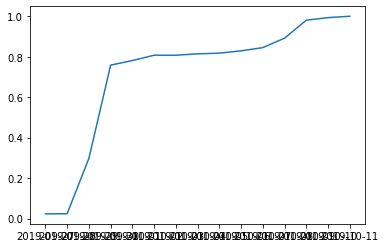

In [108]:





#################注意，这个route1与我们的预测不符，我们预测的该流向顾客订箱习惯为后期型（偏好值大于0），但它是前期型，故先不讨论它，好在
#################其他的route都是后期型

#################不过也不妨加上第一个route，至少我们的预测对大部分船还是满足的，说明模型还可以，毕竟太完美的模型也不是很令人信服
#################这个可以加到模型缺点、敏感性分析、demo里







#分析航次route1：
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route1)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-09-04,160.0,0.006920
2019-09-05,40.0,0.008651
2019-09-06,760.0,0.041522
2019-09-07,0.0,0.041522
2019-09-08,520.0,0.064014
2019-09-09,0.0,0.064014
2019-09-10,1440.0,0.126298
2019-09-11,100.0,0.130623
2019-09-12,60.0,0.133218


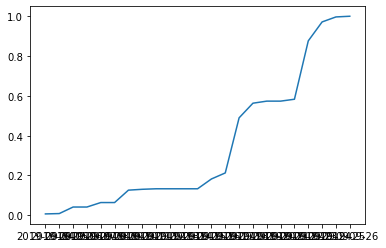

In [109]:
#对该流向，提取'IC19-CAE-199 N'航次
df_1_squ_rate_data9_SVVDgrouped_route2 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAE-199 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route2)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-10-05,1800.0,0.089109
2019-10-06,0.0,0.089109
2019-10-07,40.0,0.091089
2019-10-08,0.0,0.091089
2019-10-09,40.0,0.093069
2019-10-10,120.0,0.099010
2019-10-11,880.0,0.142574
2019-10-12,0.0,0.142574
2019-10-13,640.0,0.174257


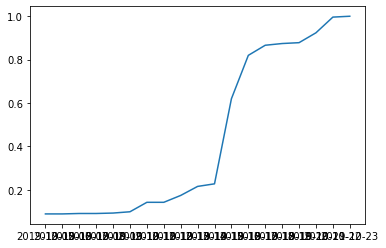

In [110]:
#对该流向，提取'IC19-CAE-200 N'航次
df_1_squ_rate_data9_SVVDgrouped_route3 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAE-200 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route3)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-09-05,40.0,0.001619
2019-09-06,40.0,0.003239
2019-09-07,0.0,0.003239
2019-09-08,80.0,0.006478
2019-09-09,0.0,0.006478
2019-09-10,60.0,0.008907
2019-09-11,0.0,0.008907
2019-09-12,20.0,0.009717
2019-09-13,0.0,0.009717


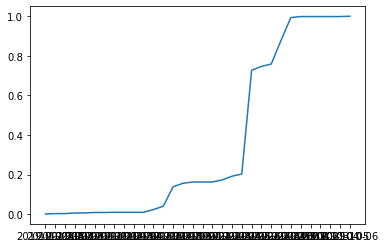

In [111]:
#对该流向，提取'IC19-CAJ-159 N'航次
df_1_squ_rate_data9_SVVDgrouped_route4 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAJ-159 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route4)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-10-05,80.0,0.003475
2019-10-06,0.0,0.003475
2019-10-07,0.0,0.003475
2019-10-08,0.0,0.003475
2019-10-09,0.0,0.003475
2019-10-10,0.0,0.003475
2019-10-11,20.0,0.004344
2019-10-12,0.0,0.004344
2019-10-13,280.0,0.016507


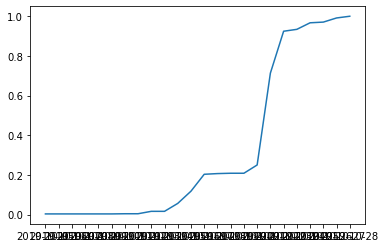

In [112]:
#对该流向，提取'IC19-CAJ-160 N'航次
df_1_squ_rate_data9_SVVDgrouped_route5 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAJ-160 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route5)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-08-15,40.0,0.001720
2019-08-16,0.0,0.001720
2019-08-17,0.0,0.001720
2019-08-18,0.0,0.001720
2019-08-19,0.0,0.001720
2019-08-20,0.0,0.001720
2019-08-21,0.0,0.001720
2019-08-22,0.0,0.001720
2019-08-23,0.0,0.001720


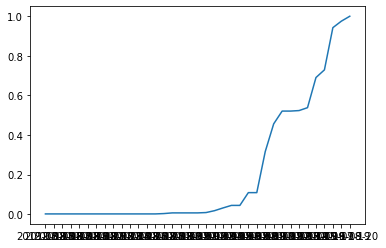

In [113]:
#对该流向，提取'IC19-CAL-191 N'航次
df_1_squ_rate_data9_SVVDgrouped_route6 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAL-191 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route6)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-09-30,160.0,0.016393
2019-10-01,0.0,0.016393
2019-10-02,0.0,0.016393
2019-10-03,0.0,0.016393
2019-10-04,0.0,0.016393
2019-10-05,280.0,0.045082
2019-10-06,140.0,0.059426
2019-10-07,40.0,0.063525
2019-10-08,600.0,0.125000


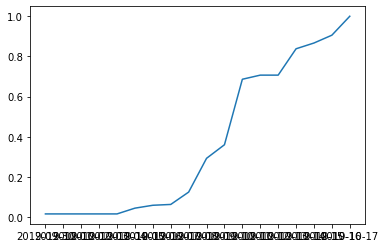

In [114]:
#IC19-CAL-192 N
#对该流向，提取'IC19-CAL-192 N'航次
df_1_squ_rate_data9_SVVDgrouped_route7 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC19-CAL-192 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route7)

,sale_volume_day,space_uti_rate
WBL_AUD_DT,,
2019-09-29,440.0,0.044715
2019-09-30,80.0,0.052846
2019-10-01,80.0,0.060976
2019-10-02,0.0,0.060976
2019-10-03,0.0,0.060976
2019-10-04,0.0,0.060976
2019-10-05,1120.0,0.174797
2019-10-06,0.0,0.174797
2019-10-07,0.0,0.174797


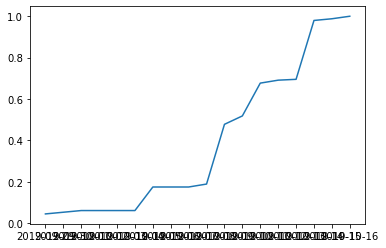

In [115]:
#IC39-TDB-042 N
#对该流向，提取'IC39-TDB-042 N'航次
df_1_squ_rate_data9_SVVDgrouped_route8 = df_1_squ_rate_data9_SVVDgrouped.get_group(('IC39-TDB-042 N'))
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route8)

In [3]:
import numpy as np

In [93]:
#原来的值：
#加价阈值：
print('加价阈值：')
print(np.array([50,60,70,70,80]))
print('降价阈值(为优化模型，我们自己加了个10)：')
print(np.array([10,30,40]))

加价阈值：
[50 60 70 70 80]
降价阈值(为优化模型，我们自己加了个10)：
[10 30 40]


In [116]:
a = 0.20684462201528928

#注意到a大于0，故它是一个后期选手，于是前期降价阈值下调，后期涨价阈值下调
#如果a小于0，它是一个前期选手，于是前期涨价阈值下调，后期降价阈值上调

#利用顾客订箱偏好优化后的值：

#以下为对后期选手（a>0）的调整策略

print('加价阈值：')
print(np.array([50,60,70,70,80])*(1-a))
print('降价阈值(为优化模型，我们自己加了个10)：')
print(np.array([10,30,40])*(1-a))

#以下为对前期选手（a<0）的调整策略
#print('加价阈值：')
#print(np.array([50,60,70,70,80])*(1-a))
#print('降价阈值(为优化模型，我们自己加了个10)：')
#print(np.array([10,30,40])*(a+1))

加价阈值：
[39.6577689  47.58932268 55.52087646 55.52087646 63.45243024]
降价阈值(为优化模型，我们自己加了个10)：
[ 7.93155378 23.79466134 31.72621512]


In [ ]:
'''
#备注：
原策略的缺点有两个：
1：没有前5天的降价策略，导致当前5天销售量持续低迷时价格居高不下（这时利用route3、route4等的图论证），没有降价刺激消费的策略，为此，我们根据观察各个船前几天的销量，自己加一个前5天的降价阈值：10
2：阈值整体不合理，没有在销量快速上升时加价，没有在销量较少时降价（这时利用route1的图论证），于是根据我们之前得到的prefer_value，对阈值作调整
（这里可以加一个调整原因的可视化）
（顾客偏好早订，应当前期调低加价阈值，使得可以在销量较大时及时加价
                    调高后期降价阈值，使得在后期销量不足的情况下及时降价）
（顾客偏好晚订，应当调低后期加价阈值，使得可以在销量较大时及时加价
                    调低前期降价阈值，可以在前期市场低迷的情况降价吸引购买）
 与此同时，我们的prefer_value $\in$ [-1,1]
 用以下函数作为变换：
 调高，就乘（a+1）
 调低，就乘（1-a）
 得到新的阈值。
'''

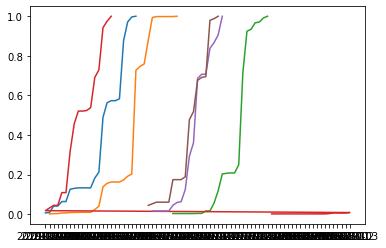

In [120]:

#这块可以不运行，我已经将数据保存

#导出数据方便画图
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route2).to_csv('route2.csv')
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route4).to_csv('route4.csv')
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route5).to_csv('route5.csv')
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route6).to_csv('route6.csv')
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route7).to_csv('route7.csv')
cal_space_uti_rate(df_1_squ_rate_data9_SVVDgrouped_route8).to_csv('route8.csv')